This is the visualization script of the paper
# Demonstration-Guided Multi-Objective Reinforcement Learning

# Import dependencies

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip3 install git+https://github.com/google-research/rliable
!pip3 install inflection
!pip install pymoo
!pip install -U rliable

  Cloning https://github.com/google-research/rliable to /tmp/pip-req-build-n5kl5q6w
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/rliable /tmp/pip-req-build-n5kl5q6w
  Resolved https://github.com/google-research/rliable to commit baaef16b3d8c8aa81b1554f3314d7b62c33670bb
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 905.4/905.4 kB 4.1 MB/s eta 0:00:00
  Created wheel for rliable: filename=rliable-1.0.8-py3-none-any.whl size=19841 sha256=093bf1a209acd05ff17245af844334e2a0e0b3db2b8c9ef8c88fa1d8bacd38bb
  Stored in directory: /tmp/pip-ephem-wheel-cache-rwyiuhic/wheels/9e/ba/1a/db74ca1d157e28c8f3402a7f8610820fbd34c22725ec1b65f9
Successfully built rliable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━

In [3]:
import scipy.stats as stats
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.colors import to_rgb
import re
from scipy.stats import gaussian_kde
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils
from pymoo.indicators.hv import HV
from copy import deepcopy

In [4]:
def load_data(env_name, seeds=[2,7,15,42,78]):
    results_DGMORL = []
    results_DGMORL_NE = []
    results_GPI_PD = []
    results_GPI_LS = []
    for seed in seeds:
        results_DGMORL.append(np.load("/content/drive/My Drive/Neurips_2024/Result/DGMORL/"+env_name+"/EU/_"+str(seed)+".npy"))
        results_GPI_PD.append(np.load("/content/drive/My Drive/Neurips_2024/Result/GPI_PD/"+env_name+"/EU/_"+str(seed)+".npy"))
        results_GPI_LS.append(np.load("/content/drive/My Drive/Neurips_2024/Result/GPI_LS/"+env_name+"/EU/_"+str(seed)+".npy"))
        results_DGMORL_NE.append(np.load("/content/drive/My Drive/Neurips_2024/Result/DGMORL_NE/"+env_name+"/EU/_"+str(seed)+".npy"))
    return results_DGMORL, results_GPI_PD, results_GPI_LS, results_DGMORL_NE

def extract(text, key_words):
    # pattern = r'disc vec return:\s*\[([ -.\d]+)\]'
    # pattern = r'demo vec:\s*\[([ -.\d]+)\]'
    # pattern = key_words+':\s*\[([ -.\d]+)\]'
    pattern = r'disc ret:\s*\[([ -.\d]+)\]'
    matches = re.findall(pattern, text)

    lists = [list(map(float, match.split())) for match in matches]
    return lists

def is_dominated(point, candidate):
    """
    Check if point is dominated by candidate.
    A point is dominated if it is worse in all objectives.
    """
    return all(c >= p for p, c in zip(point, candidate))

def find_pareto_front(points):
    """
    Find the Pareto front from a list of points.
    """
    pareto_front = []
    for point in points:
        # Check if point is dominated by any point in the current Pareto front
        if not any(is_dominated(point, pareto_point) for pareto_point in pareto_front):
            # Remove all points from Pareto front that are dominated by the new point
            pareto_front = [pareto_point for pareto_point in pareto_front if not is_dominated(pareto_point, point)]
            pareto_front.append(point)
    return pareto_front


In [5]:
def hypervolume(ref_point, points) -> float:
    """Computes the hypervolume metric for a set of points (value vectors) and a reference point (from Pymoo).

    Args:
        ref_point (np.ndarray): Reference point
        points (List[np.ndarray]): List of value vectors

    Returns:
        float: Hypervolume metric
    """
    return HV(ref_point=ref_point * -1)(np.array(points) * -1)

def sparsity(front) -> float:
    """Sparsity metric from PGMORL.

    Basically, the sparsity is the average distance between each point in the front.

    Args:
        front: current pareto front to compute the sparsity on

    Returns:
        float: sparsity metric
    """
    if len(front) < 2:
        return 0.0

    sparsity_value = 0.0
    m = len(front[0])
    front = np.array(front)
    for dim in range(m):
        objs_i = np.sort(deepcopy(front.T[dim]))
        for i in range(1, len(objs_i)):
            sparsity_value += np.square(objs_i[i] - objs_i[i - 1])
    sparsity_value /= len(front) - 1
    # print
    return sparsity_value

# Pareto Visualization

candidate:DG-MORL (ours)
Hypervolume: 68343.44
Sparsity: 36.95
HV/SP: 1849.49
-----------
candidate:DG-MORL (no self-evolving)
Hypervolume: 58508.6
Sparsity: 163.55
HV/SP: 357.74
-----------
candidate:GPI-PD
Hypervolume: 52710.74
Sparsity: 57.92
HV/SP: 910.03
-----------
candidate:GPI-LS
Hypervolume: 51545.64
Sparsity: 24.87
HV/SP: 2072.96
-----------
candidate:Initial Demo
Hypervolume: 35915.02
Sparsity: 29010.59
HV/SP: 1.24
-----------
candidate:Best Performance
Hypervolume: 53766.39
Sparsity: 4603.11
HV/SP: 11.68
-----------
candidate:DG-MORL (ours)
Hypervolume: 136021.51
Sparsity: 607.24
HV/SP: 224.0
-----------
candidate:DG-MORL (no self-evolving)
Hypervolume: 128635.06
Sparsity: 1073.22
HV/SP: 119.86
-----------
candidate:GPI-PD
Hypervolume: 103513.67
Sparsity: 1292.1
HV/SP: 80.11
-----------
candidate:GPI-LS
Hypervolume: 110327.95
Sparsity: 762.32
HV/SP: 144.73
-----------
candidate:Initial Demo
Hypervolume: 42682.51
Sparsity: 25469.52
HV/SP: 1.68
-----------
candidate:Best Perf

<ipython-input-6-1faaba57c29a>:249: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"HV/SP: {np.round_(hv_value/sparsity_,2)}")


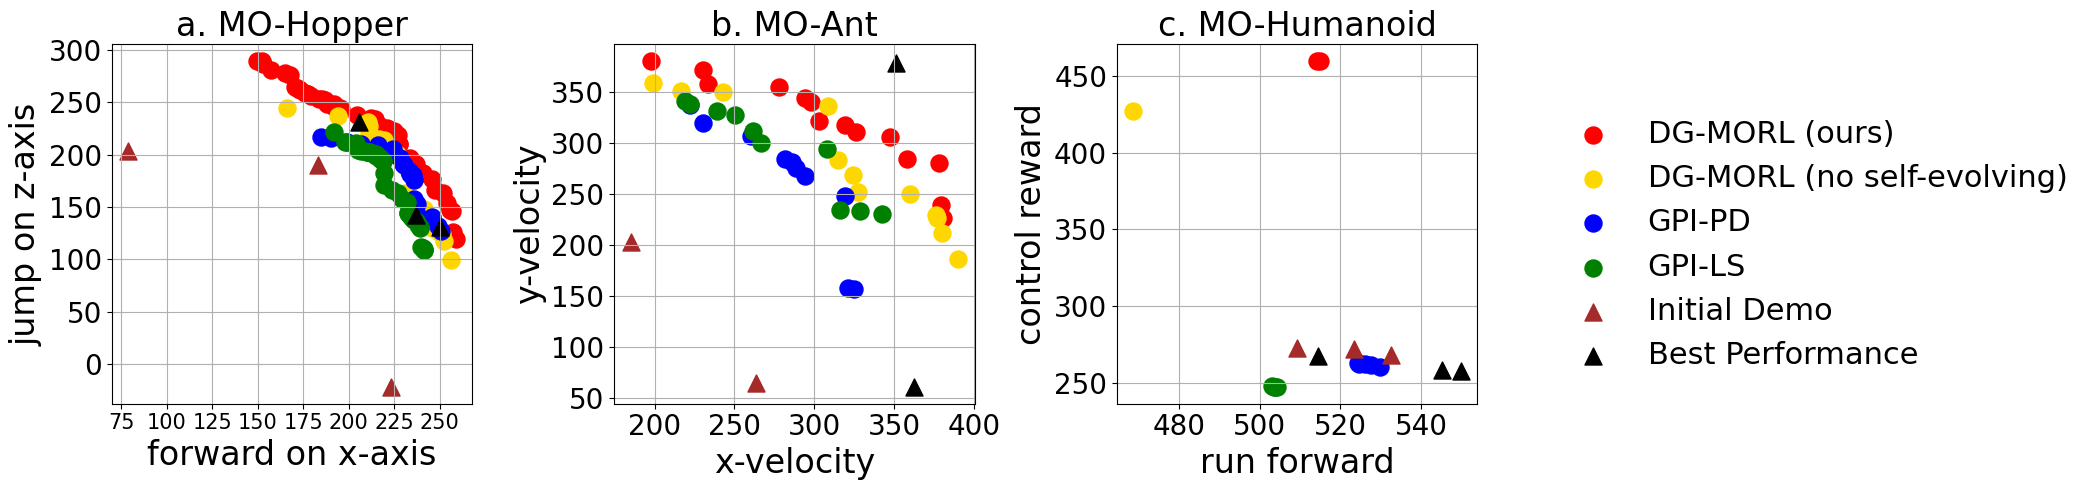

In [6]:
# Example set of points on the Pareto front
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
reference_point = np.array([0, 0])
candidates = ["DG-MORL (ours)","DG-MORL (no self-evolving)", "GPI-PD","GPI-LS", "Initial Demo", "Best Performance"]
fig.subplots_adjust(wspace=0.3)
colors = ['red', 'gold','blue', 'green', 'brown', 'black']
env_name="MO_Hopper"
x_label = "forward on x-axis"
y_label = "jump on z-axis"
title = "a. MO-Hopper"
DG_MORL_sols = np.load("/content/drive/My Drive/Neurips_2024/Result/DGMORL/"+env_name+"/PF/"+env_name+"_DGMORL_2.npy")
DG_MORL_sols = np.vstack((DG_MORL_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/DGMORL/"+env_name+"/PF/"+env_name+"_DGMORL_7.npy")))
DG_MORL_sols = np.vstack((DG_MORL_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/DGMORL/"+env_name+"/PF/"+env_name+"_DGMORL_15.npy")))
DG_MORL_sols = np.vstack((DG_MORL_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/DGMORL/"+env_name+"/PF/"+env_name+"_DGMORL_42.npy")))
DG_MORL_sols = np.vstack((DG_MORL_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/DGMORL/"+env_name+"/PF/"+env_name+"_DGMORL_78.npy")))

DG_MORL_NE_sols = np.load("/content/drive/My Drive/Neurips_2024/Result/DGMORL_NE/"+env_name+"/PF/"+env_name+"_DGMORL_NE_2.npy")
DG_MORL_NE_sols = np.vstack((DG_MORL_NE_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/DGMORL_NE/"+env_name+"/PF/"+env_name+"_DGMORL_NE_7.npy")))
DG_MORL_NE_sols = np.vstack((DG_MORL_NE_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/DGMORL_NE/"+env_name+"/PF/"+env_name+"_DGMORL_NE_15.npy")))
DG_MORL_NE_sols = np.vstack((DG_MORL_NE_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/DGMORL_NE/"+env_name+"/PF/"+env_name+"_DGMORL_NE_42.npy")))
DG_MORL_NE_sols = np.vstack((DG_MORL_NE_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/DGMORL_NE/"+env_name+"/PF/"+env_name+"_DGMORL_NE_78.npy")))

GPI_LS_sols = np.load("/content/drive/My Drive/Neurips_2024/Result/GPI_LS/"+env_name+"/PF/"+env_name+"_GPI_LS_2.npy")
GPI_LS_sols = np.vstack((GPI_LS_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/GPI_LS/"+env_name+"/PF/"+env_name+"_GPI_LS_7.npy")))
GPI_LS_sols = np.vstack((GPI_LS_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/GPI_LS/"+env_name+"/PF/"+env_name+"_GPI_LS_15.npy")))
GPI_LS_sols = np.vstack((GPI_LS_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/GPI_LS/"+env_name+"/PF/"+env_name+"_GPI_LS_42.npy")))
GPI_LS_sols = np.vstack((GPI_LS_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/GPI_LS/"+env_name+"/PF/"+env_name+"_GPI_LS_78.npy")))

GPI_PD_sols = np.load("/content/drive/My Drive/Neurips_2024/Result/GPI_PD/"+env_name+"/PF/"+env_name+"_GPI_PD_2.npy")
GPI_PD_sols = np.vstack((GPI_PD_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/GPI_PD/"+env_name+"/PF/"+env_name+"_GPI_PD_7.npy")))
GPI_PD_sols = np.vstack((GPI_PD_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/GPI_PD/"+env_name+"/PF/"+env_name+"_GPI_PD_15.npy")))
GPI_PD_sols = np.vstack((GPI_PD_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/GPI_PD/"+env_name+"/PF/"+env_name+"_GPI_PD_42.npy")))
GPI_PD_sols = np.vstack((GPI_PD_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/GPI_PD/"+env_name+"/PF/"+env_name+"_GPI_PD_78.npy")))

Initial_Demo_sols = np.load("/content/drive/My Drive/Neurips_2024/Result/Initial_Demo/"+env_name+"/PF/"+env_name+"_Initial_Demo_2.npy")
Initial_Demo_sols = np.vstack((Initial_Demo_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/Initial_Demo/"+env_name+"/PF/"+env_name+"_Initial_Demo_7.npy")))
Initial_Demo_sols = np.vstack((Initial_Demo_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/Initial_Demo/"+env_name+"/PF/"+env_name+"_Initial_Demo_15.npy")))
Initial_Demo_sols = np.vstack((Initial_Demo_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/Initial_Demo/"+env_name+"/PF/"+env_name+"_Initial_Demo_42.npy")))
Initial_Demo_sols = np.vstack((Initial_Demo_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/Initial_Demo/"+env_name+"/PF/"+env_name+"_Initial_Demo_78.npy")))

Best_Demo_sols = np.load("/content/drive/My Drive/Neurips_2024/Result/Best_Demo/"+env_name+"/PF/"+env_name+"_Best_Demo_2.npy")
Best_Demo_sols = np.vstack((Best_Demo_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/Best_Demo/"+env_name+"/PF/"+env_name+"_Best_Demo_7.npy")))
Best_Demo_sols = np.vstack((Best_Demo_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/Best_Demo/"+env_name+"/PF/"+env_name+"_Best_Demo_15.npy")))
Best_Demo_sols = np.vstack((Best_Demo_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/Best_Demo/"+env_name+"/PF/"+env_name+"_Best_Demo_42.npy")))
Best_Demo_sols = np.vstack((Best_Demo_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/Best_Demo/"+env_name+"/PF/"+env_name+"_Best_Demo_78.npy")))

pareto_fronts = [
    np.array(find_pareto_front(DG_MORL_sols)),
    np.array(find_pareto_front(DG_MORL_NE_sols)),
    np.array(find_pareto_front(GPI_PD_sols)),
    np.array(find_pareto_front(GPI_LS_sols)),
    np.array(find_pareto_front(Initial_Demo_sols)),
    np.array(find_pareto_front(Best_Demo_sols)),
    ]

HVs = []
Sps = []

for i in range(len(pareto_fronts)):
    pareto_front = pareto_fronts[i]
    hv_value = hypervolume(reference_point, pareto_front)
    sparsity_ = sparsity(pareto_front)
    HVs.append(hv_value)
    Sps.append(sparsity_)
    print(f"candidate:{candidates[i]}")
    print("Hypervolume:", np.round_(hv_value,2))
    print(f"Sparsity: {np.round_(sparsity_,2)}")
    print(f"HV/SP: {np.round_(hv_value/sparsity_,2)}")
    print("-----------")

# labels=[f"{candidates[i]} -> HV={np.round_(HVs[i],2)} | Sp={np.round_(Sps[i],2)} | HV/Sp={np.round_(HVs[i]/Sps[i],2)}" for i in range(len(HVs))]
# colors = ['#16afcc', '#0e72cc', '#bf7334', '#9c403d']

for i, points in enumerate(pareto_fronts):
    marker = "o"
    if i > 3:
        marker = "^"
    axs[0].scatter(points[:, 0],
                   points[:, 1],
                   color=colors[i],
                   s=150,
                   alpha = 1,
                   marker=marker)

axs[0].set_xlabel(x_label, fontsize=24)
axs[0].set_ylabel(y_label, fontsize=24)
axs[0].set_title(title, fontsize=24)

for label in axs[0].get_xticklabels():
    label.set_fontsize(15)
for label in axs[0].get_yticklabels():
    label.set_fontsize(20)

axs[0].grid(True)
#=====================================================================#
env_name="MO_Ant"
x_label = "x-velocity"
y_label = "y-velocity"
title = "b. MO-Ant"
DG_MORL_sols = np.load("/content/drive/My Drive/Neurips_2024/Result/DGMORL/"+env_name+"/PF/"+env_name+"_DGMORL_2.npy")
DG_MORL_sols = np.vstack((DG_MORL_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/DGMORL/"+env_name+"/PF/"+env_name+"_DGMORL_7.npy")))
DG_MORL_sols = np.vstack((DG_MORL_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/DGMORL/"+env_name+"/PF/"+env_name+"_DGMORL_15.npy")))
DG_MORL_sols = np.vstack((DG_MORL_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/DGMORL/"+env_name+"/PF/"+env_name+"_DGMORL_42.npy")))
DG_MORL_sols = np.vstack((DG_MORL_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/DGMORL/"+env_name+"/PF/"+env_name+"_DGMORL_78.npy")))

DG_MORL_NE_sols = np.load("/content/drive/My Drive/Neurips_2024/Result/DGMORL_NE/"+env_name+"/PF/"+env_name+"_DGMORL_NE_2.npy")
DG_MORL_NE_sols = np.vstack((DG_MORL_NE_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/DGMORL_NE/"+env_name+"/PF/"+env_name+"_DGMORL_NE_7.npy")))
DG_MORL_NE_sols = np.vstack((DG_MORL_NE_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/DGMORL_NE/"+env_name+"/PF/"+env_name+"_DGMORL_NE_15.npy")))
DG_MORL_NE_sols = np.vstack((DG_MORL_NE_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/DGMORL_NE/"+env_name+"/PF/"+env_name+"_DGMORL_NE_42.npy")))
DG_MORL_NE_sols = np.vstack((DG_MORL_NE_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/DGMORL_NE/"+env_name+"/PF/"+env_name+"_DGMORL_NE_78.npy")))

GPI_LS_sols = np.load("/content/drive/My Drive/Neurips_2024/Result/GPI_LS/"+env_name+"/PF/"+env_name+"_GPI_LS_2.npy")
GPI_LS_sols = np.vstack((GPI_LS_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/GPI_LS/"+env_name+"/PF/"+env_name+"_GPI_LS_7.npy")))
GPI_LS_sols = np.vstack((GPI_LS_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/GPI_LS/"+env_name+"/PF/"+env_name+"_GPI_LS_15.npy")))
GPI_LS_sols = np.vstack((GPI_LS_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/GPI_LS/"+env_name+"/PF/"+env_name+"_GPI_LS_42.npy")))
GPI_LS_sols = np.vstack((GPI_LS_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/GPI_LS/"+env_name+"/PF/"+env_name+"_GPI_LS_78.npy")))

GPI_PD_sols = np.load("/content/drive/My Drive/Neurips_2024/Result/GPI_PD/"+env_name+"/PF/"+env_name+"_GPI_PD_2.npy")
GPI_PD_sols = np.vstack((GPI_PD_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/GPI_PD/"+env_name+"/PF/"+env_name+"_GPI_PD_7.npy")))
GPI_PD_sols = np.vstack((GPI_PD_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/GPI_PD/"+env_name+"/PF/"+env_name+"_GPI_PD_15.npy")))
GPI_PD_sols = np.vstack((GPI_PD_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/GPI_PD/"+env_name+"/PF/"+env_name+"_GPI_PD_42.npy")))
GPI_PD_sols = np.vstack((GPI_PD_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/GPI_PD/"+env_name+"/PF/"+env_name+"_GPI_PD_78.npy")))

Initial_Demo_sols = np.load("/content/drive/My Drive/Neurips_2024/Result/Initial_Demo/"+env_name+"/PF/"+env_name+"_Initial_Demo_2.npy")
Initial_Demo_sols = np.vstack((Initial_Demo_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/Initial_Demo/"+env_name+"/PF/"+env_name+"_Initial_Demo_7.npy")))
Initial_Demo_sols = np.vstack((Initial_Demo_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/Initial_Demo/"+env_name+"/PF/"+env_name+"_Initial_Demo_15.npy")))
Initial_Demo_sols = np.vstack((Initial_Demo_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/Initial_Demo/"+env_name+"/PF/"+env_name+"_Initial_Demo_42.npy")))
Initial_Demo_sols = np.vstack((Initial_Demo_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/Initial_Demo/"+env_name+"/PF/"+env_name+"_Initial_Demo_78.npy")))

Best_Demo_sols = np.load("/content/drive/My Drive/Neurips_2024/Result/Best_Demo/"+env_name+"/PF/"+env_name+"_Best_Demo_2.npy")
Best_Demo_sols = np.vstack((Best_Demo_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/Best_Demo/"+env_name+"/PF/"+env_name+"_Best_Demo_7.npy")))
Best_Demo_sols = np.vstack((Best_Demo_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/Best_Demo/"+env_name+"/PF/"+env_name+"_Best_Demo_15.npy")))
Best_Demo_sols = np.vstack((Best_Demo_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/Best_Demo/"+env_name+"/PF/"+env_name+"_Best_Demo_42.npy")))
Best_Demo_sols = np.vstack((Best_Demo_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/Best_Demo/"+env_name+"/PF/"+env_name+"_Best_Demo_78.npy")))

pareto_fronts = [
    np.array(find_pareto_front(DG_MORL_sols)),
    np.array(find_pareto_front(DG_MORL_NE_sols)),
    np.array(find_pareto_front(GPI_PD_sols)),
    np.array(find_pareto_front(GPI_LS_sols)),
    np.array(find_pareto_front(Initial_Demo_sols)),
    np.array(find_pareto_front(Best_Demo_sols)),
    ]

HVs = []
Sps = []

for i in range(len(pareto_fronts)):
    pareto_front = pareto_fronts[i]
    hv_value = hypervolume(reference_point, pareto_front)
    sparsity_ = sparsity(pareto_front)
    HVs.append(hv_value)
    Sps.append(sparsity_)
    print(f"candidate:{candidates[i]}")
    print("Hypervolume:", np.round_(hv_value,2))
    print(f"Sparsity: {np.round_(sparsity_,2)}")
    print(f"HV/SP: {np.round_(hv_value/sparsity_,2)}")
    print("-----------")

# labels=[f"{candidates[i]} -> HV={np.round_(HVs[i],2)} | Sp={np.round_(Sps[i],2)} | HV/Sp={np.round_(HVs[i]/Sps[i],2)}" for i in range(len(HVs))]
# colors = ['#16afcc', '#0e72cc', '#bf7334', '#9c403d']

for i, points in enumerate(pareto_fronts):
    marker = "o"
    if i > 3:
        marker = "^"
    axs[1].scatter(points[:, 0],
                   points[:, 1],
                   color=colors[i],
                   s=150,
                   alpha = 1,
                   marker=marker)

axs[1].set_xlabel(x_label, fontsize=24)
axs[1].set_ylabel(y_label, fontsize=24)
axs[1].set_title(title, fontsize=24)

for label in axs[1].get_xticklabels():
    label.set_fontsize(20)
for label in axs[1].get_yticklabels():
    label.set_fontsize(20)

axs[1].grid(True)
#=====================================================================#
env_name="MO_Humanoid"
x_label = "run forward"
y_label = "control reward"
title = "c. MO-Humanoid"

DG_MORL_sols = np.load("/content/drive/My Drive/Neurips_2024/Result/DGMORL/"+env_name+"/PF/"+env_name+"_DGMORL_2.npy")
DG_MORL_sols = np.vstack((DG_MORL_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/DGMORL/"+env_name+"/PF/"+env_name+"_DGMORL_7.npy")))
DG_MORL_sols = np.vstack((DG_MORL_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/DGMORL/"+env_name+"/PF/"+env_name+"_DGMORL_15.npy")))
DG_MORL_sols = np.vstack((DG_MORL_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/DGMORL/"+env_name+"/PF/"+env_name+"_DGMORL_42.npy")))
DG_MORL_sols = np.vstack((DG_MORL_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/DGMORL/"+env_name+"/PF/"+env_name+"_DGMORL_78.npy")))

DG_MORL_NE_sols = np.load("/content/drive/My Drive/Neurips_2024/Result/DGMORL_NE/"+env_name+"/PF/"+env_name+"_DGMORL_NE_2.npy")
DG_MORL_NE_sols = np.vstack((DG_MORL_NE_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/DGMORL_NE/"+env_name+"/PF/"+env_name+"_DGMORL_NE_7.npy")))
DG_MORL_NE_sols = np.vstack((DG_MORL_NE_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/DGMORL_NE/"+env_name+"/PF/"+env_name+"_DGMORL_NE_15.npy")))
DG_MORL_NE_sols = np.vstack((DG_MORL_NE_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/DGMORL_NE/"+env_name+"/PF/"+env_name+"_DGMORL_NE_42.npy")))
DG_MORL_NE_sols = np.vstack((DG_MORL_NE_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/DGMORL_NE/"+env_name+"/PF/"+env_name+"_DGMORL_NE_78.npy")))

GPI_LS_sols = np.load("/content/drive/My Drive/Neurips_2024/Result/GPI_LS/"+env_name+"/PF/"+env_name+"_GPI_LS_2.npy")
GPI_LS_sols = np.vstack((GPI_LS_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/GPI_LS/"+env_name+"/PF/"+env_name+"_GPI_LS_7.npy")))
GPI_LS_sols = np.vstack((GPI_LS_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/GPI_LS/"+env_name+"/PF/"+env_name+"_GPI_LS_15.npy")))
GPI_LS_sols = np.vstack((GPI_LS_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/GPI_LS/"+env_name+"/PF/"+env_name+"_GPI_LS_42.npy")))
GPI_LS_sols = np.vstack((GPI_LS_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/GPI_LS/"+env_name+"/PF/"+env_name+"_GPI_LS_78.npy")))

GPI_PD_sols = np.load("/content/drive/My Drive/Neurips_2024/Result/GPI_PD/"+env_name+"/PF/"+env_name+"_GPI_PD_2.npy")
GPI_PD_sols = np.vstack((GPI_PD_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/GPI_PD/"+env_name+"/PF/"+env_name+"_GPI_PD_7.npy")))
GPI_PD_sols = np.vstack((GPI_PD_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/GPI_PD/"+env_name+"/PF/"+env_name+"_GPI_PD_15.npy")))
GPI_PD_sols = np.vstack((GPI_PD_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/GPI_PD/"+env_name+"/PF/"+env_name+"_GPI_PD_42.npy")))
GPI_PD_sols = np.vstack((GPI_PD_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/GPI_PD/"+env_name+"/PF/"+env_name+"_GPI_PD_78.npy")))
Initial_Demo_sols = np.load("/content/drive/My Drive/Neurips_2024/Result/Initial_Demo/"+env_name+"/PF/"+env_name+"_Initial_Demo_2.npy")
Initial_Demo_sols = np.vstack((Initial_Demo_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/Initial_Demo/"+env_name+"/PF/"+env_name+"_Initial_Demo_7.npy")))
Initial_Demo_sols = np.vstack((Initial_Demo_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/Initial_Demo/"+env_name+"/PF/"+env_name+"_Initial_Demo_15.npy")))
Initial_Demo_sols = np.vstack((Initial_Demo_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/Initial_Demo/"+env_name+"/PF/"+env_name+"_Initial_Demo_42.npy")))
Initial_Demo_sols = np.vstack((Initial_Demo_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/Initial_Demo/"+env_name+"/PF/"+env_name+"_Initial_Demo_78.npy")))

Best_Demo_sols = np.load("/content/drive/My Drive/Neurips_2024/Result/Best_Demo/"+env_name+"/PF/"+env_name+"_Best_Demo_2.npy")
Best_Demo_sols = np.vstack((Best_Demo_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/Best_Demo/"+env_name+"/PF/"+env_name+"_Best_Demo_7.npy")))
Best_Demo_sols = np.vstack((Best_Demo_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/Best_Demo/"+env_name+"/PF/"+env_name+"_Best_Demo_15.npy")))
Best_Demo_sols = np.vstack((Best_Demo_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/Best_Demo/"+env_name+"/PF/"+env_name+"_Best_Demo_42.npy")))
Best_Demo_sols = np.vstack((Best_Demo_sols, np.load("/content/drive/My Drive/Neurips_2024/Result/Best_Demo/"+env_name+"/PF/"+env_name+"_Best_Demo_78.npy")))

pareto_fronts = [
    np.array(find_pareto_front(DG_MORL_sols)),
    np.array(find_pareto_front(DG_MORL_NE_sols)),
    np.array(find_pareto_front(GPI_PD_sols)),
    np.array(find_pareto_front(GPI_LS_sols)),
    np.array(find_pareto_front(Initial_Demo_sols)),
    np.array(find_pareto_front(Best_Demo_sols)),
    ]

HVs = []
Sps = []

for i in range(len(pareto_fronts)):
    pareto_front = pareto_fronts[i]
    print(pareto_front)
    print("---")
    print(reference_point)
    hv_value = hypervolume(reference_point, pareto_front)
    sparsity_ = sparsity(pareto_front)
    HVs.append(hv_value)
    Sps.append(sparsity_)
    print(f"candidate:{candidates[i]}")
    print("Hypervolume:", np.round_(hv_value,2))
    print(f"Sparsity: {np.round_(sparsity_,2)}")
    print(f"HV/SP: {np.round_(hv_value/sparsity_,2)}")
    print("-----------")

labels=[f"{candidates[i]}" for i in range(len(HVs))]
# colors = ['red', 'green', 'blue', '#9c403d']

for i, points in enumerate(pareto_fronts):
    marker = "o"
    if i > 3:
        marker = "^"
    print(i)
    axs[2].scatter(points[:, 0],
                   points[:, 1],
                   color=colors[i],
                   label=f'{labels[i]}',
                   s=150,
                   alpha = 1,
                   marker=marker)

axs[2].set_xlabel(x_label, fontsize=24)
axs[2].set_ylabel(y_label, fontsize=24)
axs[2].set_title(title, fontsize=24)

for label in axs[2].get_xticklabels():
    label.set_fontsize(20)
for label in axs[2].get_yticklabels():
    label.set_fontsize(20)

axs[2].grid(True)

axs[3].axis('off')


fig.legend(loc='center right', bbox_to_anchor=(1.05,0.5),fontsize = 22, frameon=False)

plt.tight_layout()
plt.show()

# Stratified Bootstrap
@ Agarwal, Rishabh, et al. "Deep reinforcement learning at the edge of the statistical precipice." Advances in neural information processing systems 34 (2021): 29304-29320.

In [7]:
StratifiedBootstrap = rly.StratifiedBootstrap
IQM = lambda x: metrics.aggregate_iqm(x) # Interquartile Mean
OG = lambda x: metrics.aggregate_optimality_gap(x, 225.5106/190.95356095771032) # Optimality Gap
MEAN = lambda x: metrics.aggregate_mean(x)
MEDIAN = lambda x: metrics.aggregate_median(x)

In [8]:
def straitified_bootstrap_CI(env_name,reps=50000,task_num=15):
    results_DGMORL, results_GPI_PD, results_GPI_LS, result_DGMORL_NE = load_data(env_name)
    results_box_DGMORL = np.transpose(results_DGMORL)
    results_box_GPI_PD = np.transpose(results_GPI_PD)
    results_box_GPI_LS = np.transpose(results_GPI_LS)
    result_DGMORL_NE = np.transpose(result_DGMORL_NE)
    evals = [str(i) for i in range(0,task_num)]
    algorithms = ['DGMORL', 'GPI-PD', 'GPI-LS','DGMORL_NE']
    normalized_EU = {eval:{'DGMORL':np.array(results_box_DGMORL[int(eval)].reshape(-1, 1)),
                        'GPI-PD':np.array(results_box_GPI_PD[int(eval)].reshape(-1, 1)),
                        'GPI-LS':np.array(results_box_GPI_LS[int(eval)].reshape(-1, 1)),
                        'DGMORL_NE':np.array(result_DGMORL_NE[int(eval)].reshape(-1, 1)),} for eval in evals}
    aggregate_func = lambda x: np.array([MEDIAN(x), IQM(x), MEAN(x), OG(x)])

    DGMORL_MEDIANs = []
    DGMORL_MEDIANs_max = []
    DGMORL_MEDIANs_min = []
    DGMORL_IQMs = []
    DGMORL_IQMs_max = []
    DGMORL_IQMs_min = []
    DGMORL_MEANs = []
    DGMORL_MEANs_max = []
    DGMORL_MEANs_min = []
    DGMORL_OGs = []
    DGMORL_OGs_max = []
    DGMORL_OGs_min = []

    DGMORL_NE_MEDIANs = []
    DGMORL_NE_MEDIANs_max = []
    DGMORL_NE_MEDIANs_min = []
    DGMORL_NE_IQMs = []
    DGMORL_NE_IQMs_max = []
    DGMORL_NE_IQMs_min = []
    DGMORL_NE_MEANs = []
    DGMORL_NE_MEANs_max = []
    DGMORL_NE_MEANs_min = []
    DGMORL_NE_OGs = []
    DGMORL_NE_OGs_max = []
    DGMORL_NE_OGs_min = []

    GPI_PD_MEDIANs = []
    GPI_PD_MEDIANs_max = []
    GPI_PD_MEDIANs_min = []
    GPI_PD_IQMs = []
    GPI_PD_IQMs_max = []
    GPI_PD_IQMs_min = []
    GPI_PD_MEANs = []
    GPI_PD_MEANs_max = []
    GPI_PD_MEANs_min = []
    GPI_PD_OGs = []
    GPI_PD_OGs_max = []
    GPI_PD_OGs_min = []

    GPI_LS_MEDIANs = []
    GPI_LS_MEDIANs_max = []
    GPI_LS_MEDIANs_min = []
    GPI_LS_IQMs = []
    GPI_LS_IQMs_max = []
    GPI_LS_IQMs_min = []
    GPI_LS_MEANs = []
    GPI_LS_MEANs_max = []
    GPI_LS_MEANs_min = []
    GPI_LS_OGs = []
    GPI_LS_OGs_max = []
    GPI_LS_OGs_min = []

    for eval in evals:
        aggregate_scores, aggregate_interval_estimates = rly.get_interval_estimates(normalized_EU[eval], aggregate_func, reps=reps,confidence_interval_size=0.95)
        DGMORL_MEDIANs.append(aggregate_scores['DGMORL'][0])
        DGMORL_IQMs.append(aggregate_scores['DGMORL'][1])
        DGMORL_MEANs.append(aggregate_scores['DGMORL'][2])
        DGMORL_OGs.append(aggregate_scores['DGMORL'][3])

        DGMORL_MEDIANs_min.append(aggregate_interval_estimates['DGMORL'][0][0])
        DGMORL_IQMs_min.append(aggregate_interval_estimates['DGMORL'][0][1])
        DGMORL_MEANs_min.append(aggregate_interval_estimates['DGMORL'][0][2])
        DGMORL_OGs_min.append(aggregate_interval_estimates['DGMORL'][0][3])

        DGMORL_MEDIANs_max.append(aggregate_interval_estimates['DGMORL'][1][0])
        DGMORL_IQMs_max.append(aggregate_interval_estimates['DGMORL'][1][1])
        DGMORL_MEANs_max.append(aggregate_interval_estimates['DGMORL'][1][2])
        DGMORL_OGs_max.append(aggregate_interval_estimates['DGMORL'][1][3])


        GPI_PD_MEDIANs.append(aggregate_scores['GPI-PD'][0])
        GPI_PD_IQMs.append(aggregate_scores['GPI-PD'][1])
        GPI_PD_MEANs.append(aggregate_scores['GPI-PD'][2])
        GPI_PD_OGs.append(aggregate_scores['GPI-PD'][3])


        GPI_PD_MEDIANs_min.append(aggregate_interval_estimates['GPI-PD'][0][0])
        GPI_PD_IQMs_min.append(aggregate_interval_estimates['GPI-PD'][0][1])
        GPI_PD_MEANs_min.append(aggregate_interval_estimates['GPI-PD'][0][2])
        GPI_PD_OGs_min.append(aggregate_interval_estimates['GPI-PD'][0][3])

        GPI_PD_MEDIANs_max.append(aggregate_interval_estimates['GPI-PD'][1][0])
        GPI_PD_IQMs_max.append(aggregate_interval_estimates['GPI-PD'][1][1])
        GPI_PD_MEANs_max.append(aggregate_interval_estimates['GPI-PD'][1][2])
        GPI_PD_OGs_max.append(aggregate_interval_estimates['GPI-PD'][1][3])

        GPI_LS_MEDIANs.append(aggregate_scores['GPI-LS'][0])
        GPI_LS_IQMs.append(aggregate_scores['GPI-LS'][1])
        GPI_LS_MEANs.append(aggregate_scores['GPI-LS'][2])
        GPI_LS_OGs.append(aggregate_scores['GPI-LS'][3])

        GPI_LS_MEDIANs_min.append(aggregate_interval_estimates['GPI-LS'][0][0])
        GPI_LS_IQMs_min.append(aggregate_interval_estimates['GPI-LS'][0][1])
        GPI_LS_MEANs_min.append(aggregate_interval_estimates['GPI-LS'][0][2])
        GPI_LS_OGs_min.append(aggregate_interval_estimates['GPI-LS'][0][3])

        GPI_LS_MEDIANs_max.append(aggregate_interval_estimates['GPI-LS'][1][0])
        GPI_LS_IQMs_max.append(aggregate_interval_estimates['GPI-LS'][1][1])
        GPI_LS_MEANs_max.append(aggregate_interval_estimates['GPI-LS'][1][2])
        GPI_LS_OGs_max.append(aggregate_interval_estimates['GPI-LS'][1][3])

        DGMORL_NE_MEDIANs.append(aggregate_scores['DGMORL_NE'][0])
        DGMORL_NE_IQMs.append(aggregate_scores['DGMORL_NE'][1])
        DGMORL_NE_MEANs.append(aggregate_scores['DGMORL_NE'][2])
        DGMORL_NE_OGs.append(aggregate_scores['DGMORL_NE'][3])

        DGMORL_NE_MEDIANs_min.append(aggregate_interval_estimates['DGMORL_NE'][0][0])
        DGMORL_NE_IQMs_min.append(aggregate_interval_estimates['DGMORL_NE'][0][1])
        DGMORL_NE_MEANs_min.append(aggregate_interval_estimates['DGMORL_NE'][0][2])
        DGMORL_NE_OGs_min.append(aggregate_interval_estimates['DGMORL_NE'][0][3])

        DGMORL_NE_MEDIANs_max.append(aggregate_interval_estimates['DGMORL_NE'][1][0])
        DGMORL_NE_IQMs_max.append(aggregate_interval_estimates['DGMORL_NE'][1][1])
        DGMORL_NE_MEANs_max.append(aggregate_interval_estimates['DGMORL_NE'][1][2])
        DGMORL_NE_OGs_max.append(aggregate_interval_estimates['DGMORL_NE'][1][3])

    return {"IQM":{"DGMORL":[DGMORL_IQMs,DGMORL_IQMs_min,DGMORL_IQMs_max],
                   "GPI_PD": [GPI_PD_IQMs, GPI_PD_IQMs_min, GPI_PD_IQMs_max],
                   "GPI_LS": [GPI_LS_IQMs, GPI_LS_IQMs_min, GPI_LS_IQMs_max],
                   "DGMORL_NE":[DGMORL_NE_IQMs,DGMORL_NE_IQMs_min,DGMORL_NE_IQMs_max]},
        "MEDIAN":{"DGMORL":[DGMORL_MEDIANs,DGMORL_MEDIANs_min,DGMORL_MEDIANs_max],
                  "GPI_PD":[GPI_PD_MEDIANs, GPI_PD_MEDIANs_min, GPI_PD_MEDIANs_max],
                  "GPI_LS":[GPI_LS_MEDIANs, GPI_LS_MEDIANs_min, GPI_LS_MEDIANs_max],
                  "DGMORL_NE":[DGMORL_NE_MEDIANs,DGMORL_NE_MEDIANs_min,DGMORL_NE_MEDIANs_max]},
        "MEAN":{"DGMORL":[DGMORL_MEANs,DGMORL_MEANs_min,DGMORL_MEANs_max],
                "GPI_PD":[GPI_PD_MEANs, GPI_PD_MEANs_min, GPI_PD_MEANs_max],
                "GPI_LS":[GPI_LS_MEANs, GPI_LS_MEANs_min, GPI_LS_MEANs_max],
                "DGMORL_NE":[DGMORL_NE_MEANs,DGMORL_NE_MEANs_min,DGMORL_NE_MEANs_max]},
        "OG":{"DGMORL":[DGMORL_OGs,DGMORL_OGs_min,DGMORL_OGs_max],
              "GPI_PD":[GPI_PD_OGs, GPI_PD_OGs_min, GPI_PD_OGs_max],
              "GPI_LS":[GPI_LS_OGs, GPI_LS_OGs_min, GPI_LS_OGs_max],
              "DGMORL_NE":[DGMORL_NE_OGs,DGMORL_NE_OGs_min,DGMORL_NE_OGs_max],}}

# EU evaluation

[5.4809831332374275, 5.5045478041061955, 5.506197138911831, 5.50730721761441, 5.506909192378039, 5.5077871736102315, 5.506377436193977, 5.507977334819487, 5.508293020222314, 5.508334522940683]
[-0.14477868884717468, 0.08142631728509546, 0.2003666624402475, 0.24314698602927343, 0.26262202579430616, 0.26315499530979625, 0.2724212391930482, 0.2739480716528536, 0.27436371044140007, 0.275878969626751, 0.27923075289567617, 0.27705447327339744, 0.27866440249943175, 0.27870644275261774, 0.2787975053810461]
[117.46076569140597, 147.0452814287736, 169.9321230288317, 192.2432905007819, 193.49222687801614, 202.78839524273948, 207.3974771770473, 215.42865985336948, 211.51839580161882, 218.84602698596305, 223.19829491136747, 225.96814313832377, 221.61739499434955, 225.7255663916679, 222.14925923522958]
[9.509077877637404, 49.075582213884964, 86.57172743932905, 113.03288612069555, 137.80457357132386, 160.3110694730058, 173.51134603901616, 180.63478808729863, 205.41045729553022, 232.90500352890493, 24

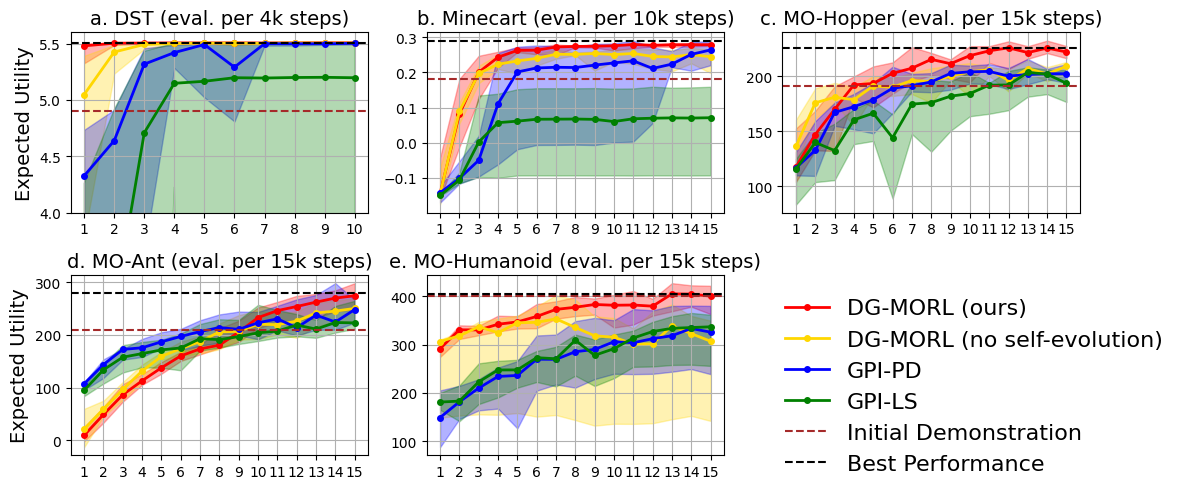

In [9]:
import matplotlib.pyplot as plt
import numpy as np
reps = 50000
task_num = 15
# 创建一个图形和子图
fig, axs = plt.subplots(2, 3, figsize=(11, 5))

# Deep Sea Treasure
result = straitified_bootstrap_CI(env_name="DST",reps=reps,task_num=10)
DGMORL_IQMs = result["IQM"]["DGMORL"][0]
DGMORL_IQMs_min = result["IQM"]["DGMORL"][1]
DGMORL_IQMs_max = result["IQM"]["DGMORL"][2]
print(DGMORL_IQMs)
GPI_PD_IQMs = result["IQM"]["GPI_PD"][0]
GPI_PD_IQMs_min = result["IQM"]["GPI_PD"][1]
GPI_PD_IQMs_max = result["IQM"]["GPI_PD"][2]

GPI_LS_IQMs = result["IQM"]["GPI_LS"][0]
GPI_LS_IQMs_min = result["IQM"]["GPI_LS"][1]
GPI_LS_IQMs_max = result["IQM"]["GPI_LS"][2]

DGMORL_NE_IQMs = result["IQM"]["DGMORL_NE"][0]
DGMORL_NE_IQMs_min = result["IQM"]["DGMORL_NE"][1]
DGMORL_NE_IQMs_max = result["IQM"]["DGMORL_NE"][2]

x =range(1, 10+1)

axs[0, 0].plot(x, DGMORL_IQMs, label='DG-MORL (ours)', color='red', linewidth=2, marker="o", markersize=4)
axs[0, 0].fill_between(x, DGMORL_IQMs_max, DGMORL_IQMs_min, color='red', alpha=0.3)

axs[0, 0].plot(x, DGMORL_NE_IQMs, label='DG-MORL (no self-evolution)', color='gold', linewidth=2, marker="o", markersize=4)
axs[0, 0].fill_between(x, DGMORL_NE_IQMs_max, DGMORL_NE_IQMs_min, color='gold', alpha=0.3)

axs[0, 0].plot(x, GPI_PD_IQMs, label='GPI-PD', color='blue', linewidth=2, marker="o", markersize=4)
axs[0, 0].fill_between(x, GPI_PD_IQMs_max, GPI_PD_IQMs_min, color='blue', alpha=0.3)

axs[0, 0].plot(x, GPI_LS_IQMs, label='GPI-LS', color='green', linewidth=2, marker="o", markersize=4)
axs[0, 0].fill_between(x, GPI_LS_IQMs_max, GPI_LS_IQMs_min, color='green', alpha=0.3)



axs[0, 0].axhline(y=4.9, color='brown', linestyle='--', label='Initial Demonstration')
axs[0, 0].axhline(y=5.5098, color='black', linestyle='--', label='Best Performance')
axs[0, 0].set_title('a. DST (eval. per 4k steps)', fontsize=14)
axs[0,0].set_ylim(4.0,5.6)
axs[0, 0].set_ylabel('Expected Utility', fontsize=14)
axs[0, 0].set_xticks(x)
axs[0, 0].grid(True)


# Minecart
result = straitified_bootstrap_CI(env_name="Minecart",reps=reps,task_num=task_num)
DGMORL_IQMs = result["IQM"]["DGMORL"][0]
print(DGMORL_IQMs)
DGMORL_IQMs_min = result["IQM"]["DGMORL"][1]
DGMORL_IQMs_max = result["IQM"]["DGMORL"][2]

GPI_PD_IQMs = result["IQM"]["GPI_PD"][0]
GPI_PD_IQMs_min = result["IQM"]["GPI_PD"][1]
GPI_PD_IQMs_max = result["IQM"]["GPI_PD"][2]

GPI_LS_IQMs = result["IQM"]["GPI_LS"][0]
GPI_LS_IQMs_min = result["IQM"]["GPI_LS"][1]
GPI_LS_IQMs_max = result["IQM"]["GPI_LS"][2]

DGMORL_NE_IQMs = result["IQM"]["DGMORL_NE"][0]
DGMORL_NE_IQMs_min = result["IQM"]["DGMORL_NE"][1]
DGMORL_NE_IQMs_max = result["IQM"]["DGMORL_NE"][2]

x =range(1, task_num+1)

axs[0, 1].plot(x, DGMORL_IQMs,  color='red', linewidth=2, marker="o", markersize=4)
axs[0, 1].fill_between(x, DGMORL_IQMs_max, DGMORL_IQMs_min, color='red', alpha=0.3)

axs[0, 1].plot(x, DGMORL_NE_IQMs, color='gold', linewidth=2, marker="o", markersize=4)
axs[0, 1].fill_between(x, DGMORL_NE_IQMs_max, DGMORL_NE_IQMs_min, color='gold', alpha=0.3)

axs[0, 1].plot(x, GPI_PD_IQMs,  color='blue', linewidth=2, marker="o", markersize=4)
axs[0, 1].fill_between(x, GPI_PD_IQMs_max, GPI_PD_IQMs_min, color='blue', alpha=0.3)

axs[0, 1].plot(x, GPI_LS_IQMs,  color='green', linewidth=2, marker="o", markersize=4)
axs[0, 1].fill_between(x, GPI_LS_IQMs_max, GPI_LS_IQMs_min, color='green', alpha=0.3)




axs[0, 1].axhline(y=0.18, color='brown', linestyle='--')
axs[0, 1].axhline(y=0.2881, color='black', linestyle='--')
axs[0, 1].set_title('b. Minecart (eval. per 10k steps)', fontsize=14)
axs[0, 1].set_xticks(x)

axs[0, 1].grid(True)

# MO Hopper
result = straitified_bootstrap_CI(env_name="MO_Hopper",reps=reps,task_num=task_num)
DGMORL_IQMs = result["IQM"]["DGMORL"][0]
print(DGMORL_IQMs)
DGMORL_IQMs_min = result["IQM"]["DGMORL"][1]
DGMORL_IQMs_max = result["IQM"]["DGMORL"][2]

GPI_PD_IQMs = result["IQM"]["GPI_PD"][0]
GPI_PD_IQMs_min = result["IQM"]["GPI_PD"][1]
GPI_PD_IQMs_max = result["IQM"]["GPI_PD"][2]

GPI_LS_IQMs = result["IQM"]["GPI_LS"][0]
GPI_LS_IQMs_min = result["IQM"]["GPI_LS"][1]
GPI_LS_IQMs_max = result["IQM"]["GPI_LS"][2]

DGMORL_NE_IQMs = result["IQM"]["DGMORL_NE"][0]
DGMORL_NE_IQMs_min = result["IQM"]["DGMORL_NE"][1]
DGMORL_NE_IQMs_max = result["IQM"]["DGMORL_NE"][2]
x =range(1, task_num+1)

axs[0, 2].plot(x, DGMORL_IQMs, color='red', linewidth=2, marker="o", markersize=4)
axs[0, 2].fill_between(x, DGMORL_IQMs_max, DGMORL_IQMs_min, color='red', alpha=0.3)

axs[0, 2].plot(x, DGMORL_NE_IQMs, color='gold', linewidth=2, marker="o", markersize=4)
axs[0, 2].fill_between(x, DGMORL_NE_IQMs_max, DGMORL_NE_IQMs_min, color='gold', alpha=0.3)

axs[0, 2].plot(x, GPI_PD_IQMs, color='blue', linewidth=2, marker="o", markersize=4)
axs[0, 2].fill_between(x, GPI_PD_IQMs_max, GPI_PD_IQMs_min, color='blue', alpha=0.3)

axs[0, 2].plot(x, GPI_LS_IQMs, color='green', linewidth=2, marker="o", markersize=4)
axs[0, 2].fill_between(x, GPI_LS_IQMs_max, GPI_LS_IQMs_min, color='green', alpha=0.3)



axs[0, 2].axhline(y=190.95356095771032, color='brown', linestyle='--')
axs[0, 2].axhline(y=225.5106, color='black', linestyle='--')
axs[0, 2].set_title('c. MO-Hopper (eval. per 15k steps)', fontsize=14)
axs[0, 2].set_xticks(x)
axs[0, 2].grid(True)

# MO-Ant
result = straitified_bootstrap_CI(env_name="MO_Ant",reps=reps,task_num=task_num)
DGMORL_IQMs = result["IQM"]["DGMORL"][0]
print(DGMORL_IQMs)
DGMORL_IQMs_min = result["IQM"]["DGMORL"][1]
DGMORL_IQMs_max = result["IQM"]["DGMORL"][2]

GPI_PD_IQMs = result["IQM"]["GPI_PD"][0]
GPI_PD_IQMs_min = result["IQM"]["GPI_PD"][1]
GPI_PD_IQMs_max = result["IQM"]["GPI_PD"][2]

GPI_LS_IQMs = result["IQM"]["GPI_LS"][0]
GPI_LS_IQMs_min = result["IQM"]["GPI_LS"][1]
GPI_LS_IQMs_max = result["IQM"]["GPI_LS"][2]


DGMORL_NE_IQMs = result["IQM"]["DGMORL_NE"][0]
DGMORL_NE_IQMs_min = result["IQM"]["DGMORL_NE"][1]
DGMORL_NE_IQMs_max = result["IQM"]["DGMORL_NE"][2]
x =range(1, task_num+1)

axs[1, 0].plot(x, DGMORL_IQMs, color='red', linewidth=2, marker="o", markersize=4)
axs[1, 0].fill_between(x, DGMORL_IQMs_max, DGMORL_IQMs_min, color='red', alpha=0.3)

axs[1, 0].plot(x, DGMORL_NE_IQMs, color='gold', linewidth=2, marker="o", markersize=4)
axs[1, 0].fill_between(x, DGMORL_NE_IQMs_max, DGMORL_NE_IQMs_min, color='gold', alpha=0.3)

axs[1, 0].plot(x, GPI_PD_IQMs, color='blue', linewidth=2, marker="o", markersize=4)
axs[1, 0].fill_between(x, GPI_PD_IQMs_max, GPI_PD_IQMs_min, color='blue', alpha=0.3)

axs[1, 0].plot(x, GPI_LS_IQMs, color='green', linewidth=2, marker="o", markersize=4)
axs[1, 0].fill_between(x, GPI_LS_IQMs_max, GPI_LS_IQMs_min, color='green', alpha=0.3)





axs[1, 0].axhline(y=208.51438198312098, color='brown', linestyle='--')
axs[1, 0].axhline(y=280, color='black', linestyle='--')
axs[1, 0].set_title('d. MO-Ant (eval. per 15k steps)', fontsize=14)

axs[1, 0].set_ylabel('Expected Utility', fontsize=14)

axs[1, 0].set_xticks(x)
axs[1, 0].grid(True)

# MO-Humanoid
result = straitified_bootstrap_CI(env_name="MO_Humanoid",reps=reps,task_num=task_num)
DGMORL_IQMs = result["IQM"]["DGMORL"][0]
print(DGMORL_IQMs)
DGMORL_IQMs_min = result["IQM"]["DGMORL"][1]
DGMORL_IQMs_max = result["IQM"]["DGMORL"][2]

GPI_PD_IQMs = result["IQM"]["GPI_PD"][0]
GPI_PD_IQMs_min = result["IQM"]["GPI_PD"][1]
GPI_PD_IQMs_max = result["IQM"]["GPI_PD"][2]

GPI_LS_IQMs = result["IQM"]["GPI_LS"][0]
GPI_LS_IQMs_min = result["IQM"]["GPI_LS"][1]
GPI_LS_IQMs_max = result["IQM"]["GPI_LS"][2]

DGMORL_NE_IQMs = result["IQM"]["DGMORL_NE"][0]
DGMORL_NE_IQMs_min = result["IQM"]["DGMORL_NE"][1]
DGMORL_NE_IQMs_max = result["IQM"]["DGMORL_NE"][2]
x =range(1, task_num+1)

axs[1, 1].plot(x, DGMORL_IQMs, color='red', linewidth=2, marker="o", markersize=4)
axs[1, 1].fill_between(x, DGMORL_IQMs_max, DGMORL_IQMs_min, color='red', alpha=0.3)

axs[1, 1].plot(x, DGMORL_NE_IQMs, color='gold', linewidth=2, marker="o", markersize=4)
axs[1, 1].fill_between(x, DGMORL_NE_IQMs_max, DGMORL_NE_IQMs_min, color='gold', alpha=0.3)

axs[1, 1].plot(x, GPI_PD_IQMs, color='blue', linewidth=2, marker="o", markersize=4)
axs[1, 1].fill_between(x, GPI_PD_IQMs_max, GPI_PD_IQMs_min, color='blue', alpha=0.3)

axs[1, 1].plot(x, GPI_LS_IQMs, color='green', linewidth=2, marker="o", markersize=4)
axs[1, 1].fill_between(x, GPI_LS_IQMs_max, GPI_LS_IQMs_min, color='green', alpha=0.3)




axs[1, 1].axhline(y=400.27566939921627, color='brown', linestyle='--')
axs[1, 1].axhline(y=404, color='black', linestyle='--')
axs[1, 1].set_title('e. MO-Humanoid (eval. per 15k steps)', fontsize=14)

# axs[1, 1].set_ylabel('Expected Utility', fontsize=14)
# axs[1, 1].set_ylim(220,420)
axs[1, 1].set_xticks(x)
axs[1, 1].grid(True)



axs[1, 2].axis('off')

fig.legend(loc='lower right', bbox_to_anchor=(1.08, 0),fontsize = 16, frameon=False)

plt.tight_layout()
plt.show()
